In [1]:
import pandas as pd
import pyLDAvis.gensim_models
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
data_=pd.read_csv('../data/data.csv')

In [5]:
data_['file_name'].unique()

array(['01 01 2023_Goldman Sachs_Caution Heavy Fog',
       '01 07 2022_Unicredit_Economics chartbook Q2',
       '01 11 2022_bnp_parisbas global view 2023',
       '01 12 2020_UBS_alternative-investments-improving-portfolio-performance',
       '01 12 2022_Goldman Sachs_global view 2023',
       '01 12 2023_kkr_global view 2023',
       '07 08 2022_Moodys_Weekly-Market-Outlook',
       '08 07 2022_CACIB_-Monde-Hebdo', '08 07 2022_Erste_Week Ahead',
       '08 07 2022_ScotiaBank_global week ahead',
       '11 07 2022_Commerz_European Sunrise',
       '11 07 2022_ING_FX Talking July22 (v3)',
       '12 31 2022_jpmorgan_asset management Q1 2023',
       '16 11 2022_Goldman Sachs_global outlook',
       '2022_jpmorgan_private banking global view 2023',
       '29 07 2022_Goldman Sachs_exemple analyse macro economique goldman sachs',
       '29 07 2022_Goldman Sachs_recession'], dtype=object)

In [3]:
data=data_.drop(['file_name','subjectivity_score'],axis=1)

In [4]:
data.date.value_counts()

date
01 01 2023    110
01 12 2023     74
12 31 2022     71
2022           55
01 07 2022     53
01 12 2020     34
01 11 2022     32
08 07 2022     29
11 07 2022     25
16 11 2022     24
07 08 2022     22
29 07 2022     14
01 12 2022      4
Name: count, dtype: int64

In [28]:
data.bank.value_counts()

bank
Goldman Sachs    152
jpmorgan         126
kkr               74
Unicredit         53
UBS               34
bnp               32
Moodys            22
ING               16
ScotiaBank        13
CACIB             10
Commerz            9
Erste              6
Name: count, dtype: int64

In [37]:
data.title.value_counts()

title
Caution Heavy Fog                                          110
global view 2023                                            78
asset management Q1 2023                                    71
private banking global view 2023                            55
Economics chartbook Q2                                      53
alternative-investments-improving-portfolio-performance     34
parisbas global view 2023                                   32
global outlook                                              24
Weekly-Market-Outlook                                       22
FX Talking July22 (v3)                                      16
global week ahead                                           13
-Monde-Hebdo                                                10
European Sunrise                                             9
exemple analyse macro economique goldman sachs               7
recession                                                    7
Week Ahead                                       

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   page_num    547 non-null    int64 
 1   text        544 non-null    object
 2   clean_text  542 non-null    object
 3   tokens      547 non-null    object
 4   date        547 non-null    object
 5   bank        547 non-null    object
 6   title       547 non-null    object
dtypes: int64(1), object(6)
memory usage: 30.0+ KB


In [5]:
data.head(2)

,page_num,text,clean_text,tokens,date,bank,title
0,1,Outlook Caution: Heavy Fog Investment Strategy...,caution heavi fog invest strategi januari weal...,"['caution', 'heavy', 'fog', 'investment', 'str...",01 01 2023,Goldman Sachs,Caution Heavy Fog
1,2,This material represents the views of the Inve...,materi repres view invest strategi wealth mana...,"['material', 'represents', 'views', 'investmen...",01 01 2023,Goldman Sachs,Caution Heavy Fog


In [6]:
data.file_name.value_counts()

AttributeError: 'DataFrame' object has no attribute 'file_name'

In [7]:
data.isna().sum()

page_num      0
text          3
clean_text    5
tokens        0
date          0
bank          0
title         0
dtype: int64

In [8]:
def topic_modeling(n_topics,text):
    processed_docs = text.tolist()
    tokenized_docs = [word_tokenize(str(doc).lower()) for doc in processed_docs]
    stop_words = set(stopwords.words('english'))
    filtered_docs = [[word for word in doc if word.lower() not in stop_words] for doc in tokenized_docs]
    dictionary = Dictionary(filtered_docs)
    dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=3000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in filtered_docs]
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics =n_topics, id2word = dictionary, passes =10)
    return lda_model,bow_corpus,dictionary 

In [27]:
lda_model,bow_corpus,dictionary =topic_modeling(2,data['clean_text'])

In [ ]:
from gensim.models import CoherenceModel

def calculate_perplexity(lda_model, corpus):
    perplexity = lda_model.log_perplexity(corpus)
    return perplexity

# Assuming you have lda_model and bow_corpus from your topic_modeling function
perplexity = calculate_perplexity(lda_model, bow_corpus)
print(f"Perplexity: {perplexity}")


Perplexity: -6.186660019034764


In [ ]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)

In [14]:
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.179615  0.0       1        1  66.560587
1     -0.179615  0.0       2        1  33.439413, topic_info=          Term        Freq       Total Category  logprob  loglift
579   document  154.000000  154.000000  Default  30.0000  30.0000
587      regul  149.000000  149.000000  Default  29.0000  29.0000
3       author  134.000000  134.000000  Default  28.0000  28.0000
284      moodi  105.000000  105.000000  Default  27.0000  27.0000
366  distribut   90.000000   90.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
245    leverag   66.942110   76.298320   Topic2  -4.9141   0.9646
178      refer   87.213238  108.570016   Topic2  -4.6496   0.8764
105       issu   70.514097   82.165725   Topic2  -4.8621   0.9425
104   institut   54.870328   60.648717   Topic2  -5.1130   0.9953
332      index   60.386964   88.993886   Topic2  -5.0172   0.7076

[121 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
446       2  0.991192  accuraci
573       1  0.014002     advic
573       2  0.994133     advic
281       1  0.029205     advis
281       2  0.992970     advis
...     ...       ...       ...
485       2  0.014831      weak
135       1  0.835003    weight
135       2  0.164648    weight
611       1  0.899971        yr
611       2  0.098627        yr

[174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [13]:
vis_html = pyLDAvis.prepared_data_to_html(vis)
with open('../pyldavis_visualization.html', 'w') as f:
    f.write(vis_html)

In [15]:
topics = []
for idx, topic in lda_model.print_topics(-1) :
    print("Topic: {} -> Words: {}".format(idx, topic))
    topics.append(topic)

Topic: 0 -> Words: 0.010*"unicredit" + 0.010*"eur" + 0.008*"apr" + 0.007*"oil" + 0.007*"cap" + 0.007*"em" + 0.006*"bp" + 0.006*"ing" + 0.006*"eurozon" + 0.006*"mar"
Topic: 1 -> Words: 0.017*"document" + 0.016*"regul" + 0.015*"author" + 0.011*"hedg" + 0.011*"report" + 0.011*"moodi" + 0.011*"correl" + 0.010*"altern" + 0.010*"distribut" + 0.010*"refer"


In [16]:
all_topic_model = []
for i in range(len(topics)):
  str = topics[i].split(' + ')
  topic_model = []
  for j in range(10):
    weight = str[j][0:5]
    word = str[j][7:len(str[j])-1]
    topic_model.append((weight, word))
  all_topic_model.append(topic_model)

In [17]:
df_topic_model = pd.DataFrame(all_topic_model)
df_topic_model.rename(index = {0: "Topic 0", 1: "Topic 1", 2: "Topic 2", 3: "Topic 3", 4: "Topic 4", 5: "Topic 5", 6: "Topic 6", 7: "Topic 7", 8: "Topic 8", 9: "Topic 9",10: "Topic 10",11: "Topic 11",12: "Topic 12",13: "Topic 13",14: "Topic 14"})

,0,1,2,3,4,5,6,7,8,9
Topic 0,"(0.010, unicredit)","(0.010, eur)","(0.008, apr)","(0.007, oil)","(0.007, cap)","(0.007, em)","(0.006, bp)","(0.006, ing)","(0.006, eurozon)","(0.006, mar)"
Topic 1,"(0.017, document)","(0.016, regul)","(0.015, author)","(0.011, hedg)","(0.011, report)","(0.011, moodi)","(0.011, correl)","(0.010, altern)","(0.010, distribut)","(0.010, refer)"


In [18]:
"""import gensim
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel


coherence_model = CoherenceModel(model=lda_model, texts=filtered_docs, dictionary=dictionary, coherence='c_v')
coherence_scores = coherence_model.get_coherence_per_topic()
most_different_topic_index = coherence_scores.index(max(coherence_scores))
most_different_topic = lda_model.show_topic(most_different_topic_index)
print(f"The most different topic is Topic {most_different_topic_index}:")
for word, score in most_different_topic:
    print(f"{word}: {score}")
"""

'import gensim\nfrom gensim.models import LdaMulticore\nfrom gensim.models import CoherenceModel\n\n\ncoherence_model = CoherenceModel(model=lda_model, texts=filtered_docs, dictionary=dictionary, coherence=\'c_v\')\ncoherence_scores = coherence_model.get_coherence_per_topic()\nmost_different_topic_index = coherence_scores.index(max(coherence_scores))\nmost_different_topic = lda_model.show_topic(most_different_topic_index)\nprint(f"The most different topic is Topic {most_different_topic_index}:")\nfor word, score in most_different_topic:\n    print(f"{word}: {score}")\n'

In [19]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

topics = []
for idx, topic in lda_model.print_topics(-1):
    topic_terms = lda_model.get_topic_terms(idx)
    term_indexes = [term_id for term_id, _ in topic_terms]
    term_words = [lda_model.id2word[term_id] for term_id in term_indexes]
    bigram_finder = BigramCollocationFinder.from_words(term_words)
    bigrams = bigram_finder.nbest(BigramAssocMeasures.pmi, 10)  # You can adjust the number of bigrams to retrieve
    bigram_words = [' '.join(bigram) for bigram in bigrams]
    print("Topic: {} -> bigram : {}".format(idx,bigram_words))


Topic: 0 -> bigram : ['apr oil', 'bp ing', 'cap em', 'em bp', 'eur apr', 'eurozon mar', 'ing eurozon', 'oil cap', 'unicredit eur']
Topic: 1 -> bigram : ['altern distribut', 'author hedg', 'correl altern', 'distribut refer', 'document regul', 'hedg report', 'moodi correl', 'regul author', 'report moodi']


In [20]:
L_topic=[]
document_topic_dist = [lda_model.get_document_topics(doc) for doc in bow_corpus]
for i, doc_topics in enumerate(document_topic_dist):
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    dominant_topic = sorted_topics[0]
    L_topic.append(dominant_topic[0])

In [21]:
data['topic']=L_topic

In [3]:
data.to_csv('../data/data_class.csv',index=False)

NameError: name 'data' is not defined

In [3]:
data_class=pd.read_csv('../data/data_class.csv')

In [5]:
data_class[['clean_text','topic']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  542 non-null    object
 1   topic       542 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB


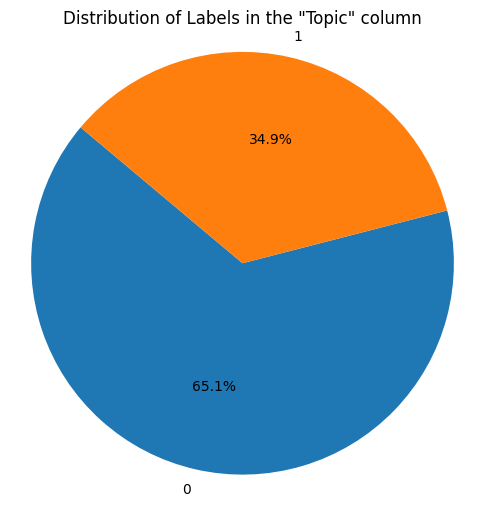

In [6]:
import matplotlib.pyplot as plt

label_counts = data_class['topic'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels in the "Topic" column')
plt.axis('equal')  

plt.show()


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_class['clean_text'],data_class['topic'], test_size=0.25, random_state=3)

NameError: name 'train_test_split' is not defined

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [57]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=3,
    objective='binary:logistic',
    colsample_bytree=0.9
)
xgb.fit(X_train_features, y_train)
y_pred = xgb.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.90


In [58]:
# Define the XGBoost model
xgb = XGBClassifier(objective='binary:logistic')

param_grid = {
    'n_estimators': [100, 200, 300,400],
    'learning_rate': [0.1, 0.12,0.05,0.08],
    'max_depth': [3, 4, 5,6],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create a grid search object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_features, y_train)

# Get the best model with optimized hyperparameters
best_xgb = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred = best_xgb.predict(X_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy:.2f}")


Best Accuracy: 0.90


In [59]:
# Access the best hyperparameters
best_params = best_xgb.get_params()
print("Best Hyperparameters:")
print(best_params)

Best Hyperparameters:
{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.08, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [60]:
from sklearn.metrics import f1_score

# Assuming you have already made predictions on the test data and stored them in y_pred
# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1:.2f}")

F1 Score: 0.84


In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

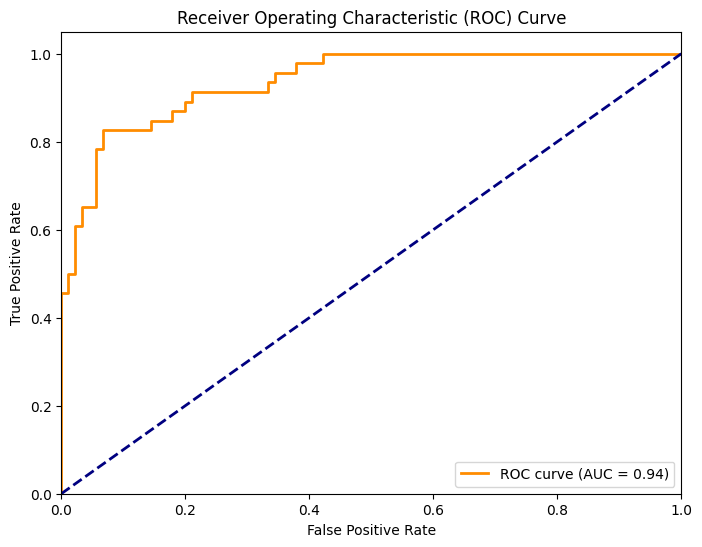

In [62]:

y_pred_prob = best_xgb.predict_proba(X_test_features)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC (Area Under the ROC Curve)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


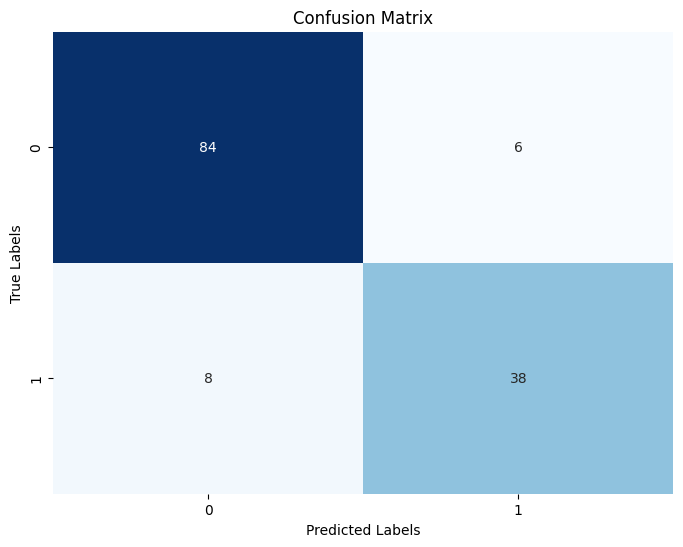

In [63]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the LogisticRegression model
lr = LogisticRegression()

# Define a grid of hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithm
    'max_iter': [100, 200, 300],  # Maximum number of iterations
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_features, y_train)

# Get the best model with optimized hyperparameters
best_lr = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred_lr = best_lr.predict(X_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Best Accuracy: {accuracy:.2f}")

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)


Best Accuracy: 0.89
Best Hyperparameters:
{'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}


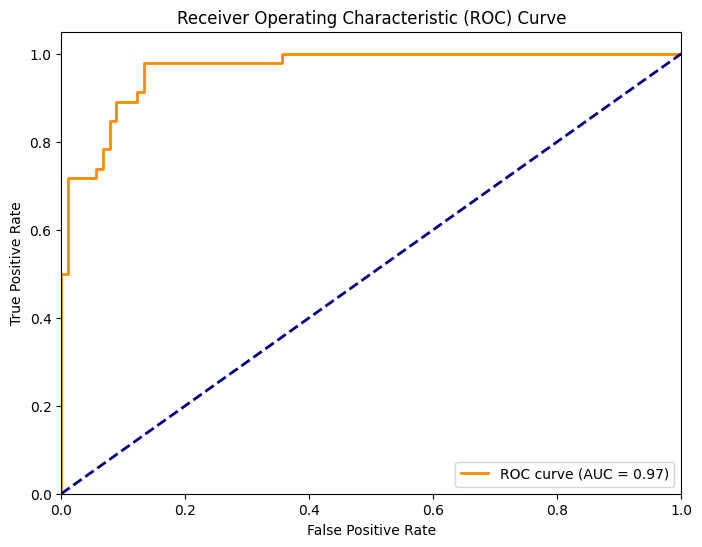

In [65]:
y_pred_prob = best_lr.predict_proba(X_test_features)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC (Area Under the ROC Curve)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


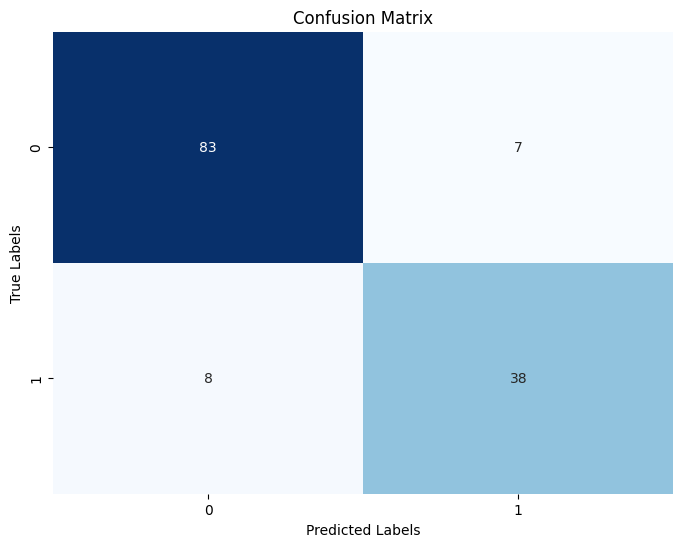

In [66]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [67]:
from sklearn.metrics import f1_score

# Assuming you have already made predictions on the test data and stored them in y_pred
# Calculate the F1 score
f1 = f1_score(y_test, y_pred_lr)

print(f"F1 Score: {f1:.2f}")

F1 Score: 0.84


In [68]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier



# Create a StackingClassifier using Logistic Regression as the meta-model
ensemble_model = StackingClassifier(
    estimators=[('lr', best_lr), ('xgb', best_xgb)],
    final_estimator=LogisticRegression()
)

# Fit the ensemble model on the training data
ensemble_model.fit(X_train_features, y_train)

# Make predictions using the ensemble model
y_pred = ensemble_model.predict(X_test_features)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy:.2f}")


Ensemble Accuracy: 0.90


In [42]:
from sklearn.metrics import f1_score

# Assuming you have already made predictions on the test data and stored them in y_pred
# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1:.2f}")

F1 Score: 0.86


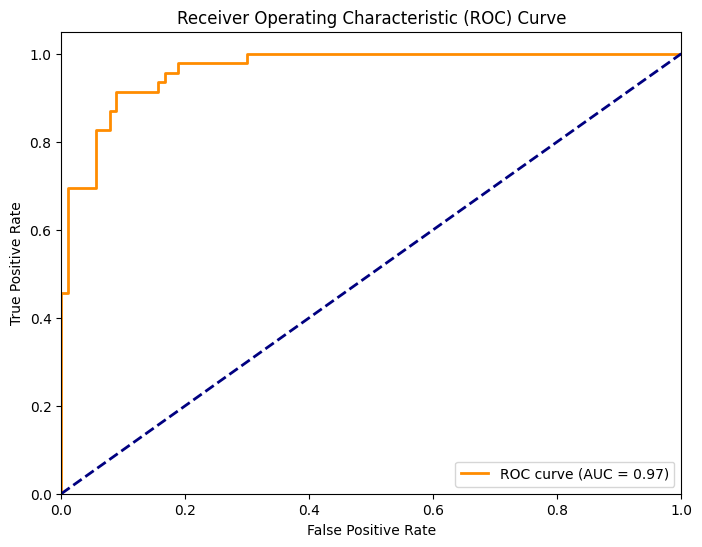

In [48]:
y_pred_prob = ensemble_model.predict_proba(X_test_features)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC (Area Under the ROC Curve)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [45]:
model_filename = 'XGBClassifier_model.pkl'
joblib.dump(best_xgb, model_filename)


['XGBClassifier_model.pkl']

In [46]:
model_filename = 'logistic_regression_model.pkl'
joblib.dump(best_lr, model_filename)


['logistic_regression_model.pkl']

In [47]:
vectorizer_filename = 'vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_filename)

['vectorizer.pkl']

In [86]:
new_document='The information presented in this analysis is based on data and research conducted by the Investment Insights Division at FinancePro. While we strive to provide accurate and reliable information, this analysis is for informational purposes only and should not be considered as financial advice. Past performance is not indicative of future results, and investment decisions should be made after consulting with a qualified financial professional. We extend our gratitude to our research team, including Jane Smith, Senior Economist, and John Doe, Investment Analyst, for their contributions to this report.'
new_document_features = vectorizer.transform([new_document])
prediction = lr.predict(new_document_features)

if prediction[0] == 1:
    print("The new document contains legal content.")
else:
    print("The new document does not contain legal content.")

The new document does not contain legal content.


In [90]:
data_f=data[:20]

In [51]:
from sklearn.metrics import classification_report

class_labels = list(set(y_test))  # Get unique class labels from y_test

In [39]:
data[data['topic']==1].to_csv('../data/legal_data.csv',index=False)

In [31]:
data[data['topic']==0].to_csv('../data/financial_data.csv',index=False)

In [32]:
data_law=pd.read_csv('../data/legal_data.csv')

In [55]:
data_law.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   file_name           189 non-null    object 
 1   page_num            189 non-null    int64  
 2   text                189 non-null    object 
 3   clean_text          189 non-null    object 
 4   tokens              189 non-null    object 
 5   subjectivity_score  189 non-null    float64
 6   date                189 non-null    object 
 7   bank                189 non-null    object 
 8   title               189 non-null    object 
 9   topic               189 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 14.9+ KB


In [58]:
data_law['text'][1]

'This material represents the views of the Investment Strategy Group in Wealth Management at Goldman Sachs. It is not a  product of Goldman Sachs Global Investment Research. The views and opinions expressed herein may differ from those  expressed by other groups of Goldman Sachs. Sharmin Mossavar-Rahmani  Chief Investment Officer  Investment Strategy Group  Goldman Sachs  Brett Nelson  Head of Tactical Asset Allocation  Investment Strategy Group  Goldman Sachs    The co-authors give special thanks to:  Matheus Dibo  Vice President Kelly Han  Vice President Rob Hunter  Vice President Harm Zebregs  Vice President Additional contributors from the   Investment Strategy Group: Matthew Weir  Managing Director Venkatesh Balasubramanian  Managing Director Oussama Fatri  Managing Director Nicola Gifford   Vice President  Arjun Menon  Vice President  Michael Murdoch  Vice President Daniel Toro  Vice President Fabian Mertes  Associate Yousra Zerouali  Associate '

## Analysing topics in the financial dataset

In [53]:
data_financial=pd.read_csv('../data/financial_data.csv')

In [54]:
data_financial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   file_name           353 non-null    object 
 1   page_num            353 non-null    int64  
 2   text                353 non-null    object 
 3   clean_text          353 non-null    object 
 4   tokens              353 non-null    object 
 5   subjectivity_score  353 non-null    float64
 6   date                353 non-null    object 
 7   bank                353 non-null    object 
 8   title               353 non-null    object 
 9   topic               353 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 27.7+ KB


In [65]:
data_financial['text'][3]

"4 Goldman Sachs january 2023   Clients' portfolios experienced more volatility in 2022 than usual because  equities and bonds declined at the same time in most markets. It is very rare to have  equities and bonds drop over the same period in the US; since 1926, i.e., across 96  years of data, a decline in both equities and bonds over a rolling 12-month window  has occurred only 5% of the time when using a 10-year benchmark for bonds,  and only 2% of the time when using a 1- to 10-year benchmark.  60/40 Stock/Bond Model Portfolios  Notwithstanding such rarity, reports issued last year by several financial  institutions challenged the 60/40 stock/bond model portfolios. Some  recommended adding real assets such as commodities, infrastructure and real  Exhibit 2: Pillars of the Investment Strategy Group's Investment Philosophy Asset allocation process is client-tailored and independent of implementation vehicles Investment Strategy Group Analytical Rigor History Is a Useful Guide Appropri

In [ ]:
data_financial.head()

,file_name,page_num,text,clean_text,tokens,subjectivity_score,date,bank,title,topic
0,01 01 2023_Goldman Sachs_Caution Heavy Fog,3,1 Outlook Investment Strategy Group 2023 OUTLO...,invest strategi client tumultu understat equit...,investment strategy clients tumultuous underst...,0.382315,01 01 2023,Goldman Sachs,Caution Heavy Fog,1
1,01 01 2023_Goldman Sachs_Caution Heavy Fog,4,2 Goldman Sachs january 2023 Among financial...,januari financi asset spare equiti measur maxi...,january financial assets spared equities measu...,0.383203,01 01 2023,Goldman Sachs,Caution Heavy Fog,1
2,01 01 2023_Goldman Sachs_Caution Heavy Fog,5,3 Outlook Investment Strategy Group descending...,invest strategi descend storag facil fill mild...,investment strategy descending storage facilit...,0.354392,01 01 2023,Goldman Sachs,Caution Heavy Fog,1
3,01 01 2023_Goldman Sachs_Caution Heavy Fog,6,4 Goldman Sachs january 2023 Clients' portfo...,januari client portfolio experienc volatil usu...,january clients portfolios experienced volatil...,0.409583,01 01 2023,Goldman Sachs,Caution Heavy Fog,1
4,01 01 2023_Goldman Sachs_Caution Heavy Fog,7,5 Outlook Investment Strategy Group estate. Ot...,invest strategi estat recommend diversifi port...,investment strategy estate recommended diversi...,0.445732,01 01 2023,Goldman Sachs,Caution Heavy Fog,1


In [ ]:
from gensim.utils import simple_preprocess
from gensim import corpora
tokens_2 = [simple_preprocess(sentence) for sentence in data_financial['clean_text']]

# Create a dictionary
dictionary_2 = corpora.Dictionary(tokens_2)

In [ ]:
from gensim.models import LdaModel

doc_term_matrix = [dictionary_2.doc2bow(doc) for doc in tokens_2]

# Define the number of topics
num_topics = 3

# Apply LDA
lda_model_2 = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary_2, passes=40)

# Print the topics
for topic in lda_model_2.show_topics():
    print(topic)

(0, '0.020*"inflat" + 0.019*"rate" + 0.013*"growth" + 0.013*"price" + 0.012*"expect" + 0.010*"gdp" + 0.009*"forecast" + 0.009*"econom" + 0.009*"jan" + 0.009*"market"')
(1, '0.020*"return" + 0.018*"equiti" + 0.017*"market" + 0.014*"exhibit" + 0.013*"asset" + 0.013*"invest" + 0.012*"yield" + 0.011*"bond" + 0.009*"fund" + 0.009*"rate"')
(2, '0.023*"china" + 0.008*"global" + 0.007*"russia" + 0.007*"risk" + 0.006*"covid" + 0.006*"product" + 0.005*"decemb" + 0.005*"emerg" + 0.005*"invest" + 0.004*"asia"')


In [ ]:
topics = lda_model_2.show_topics(num_topics=num_topics, num_words=15, formatted=False)

In [ ]:
topic_words = [[word[0] for word in topic[1]] for topic in topics]
topic_probs = [[word[1] for word in topic[1]] for topic in topics]

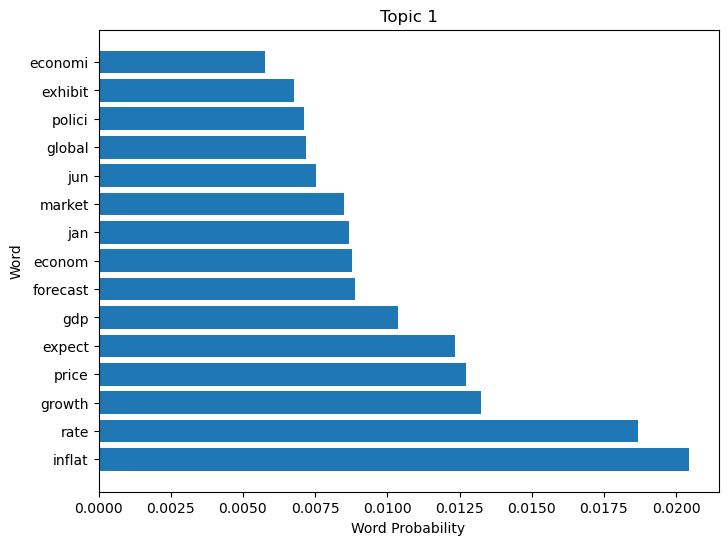

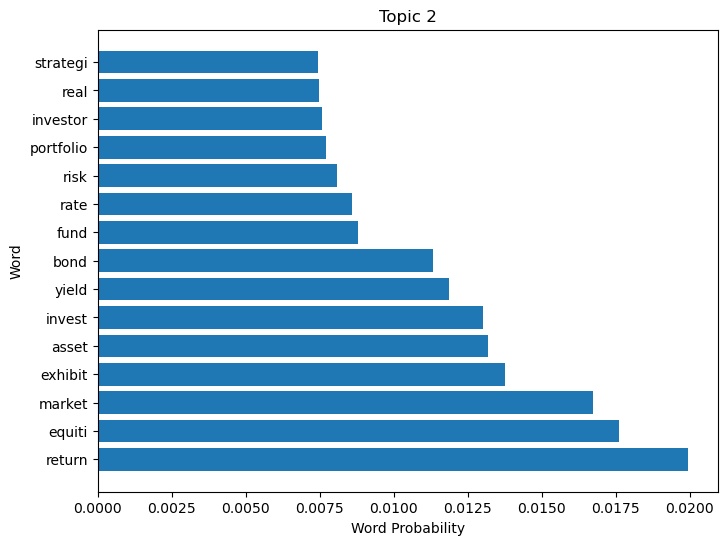

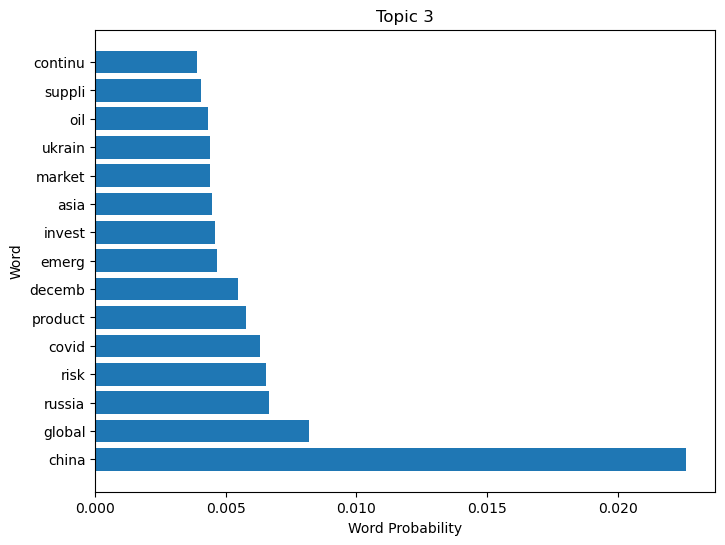

In [ ]:
import matplotlib.pyplot as plt

# Plotting bar charts for each topic
for i in range(num_topics):
    plt.figure(figsize=(8, 6))
    plt.barh(topic_words[i], topic_probs[i])
    plt.title(f'Topic {i+1}')
    plt.xlabel('Word Probability')
    plt.ylabel('Word')
    plt.show()

c:\Users\rimai\AppData\Local\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\rimai\AppData\Local\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\rimai\AppData\Local\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\rimai\AppData\Local\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is depre

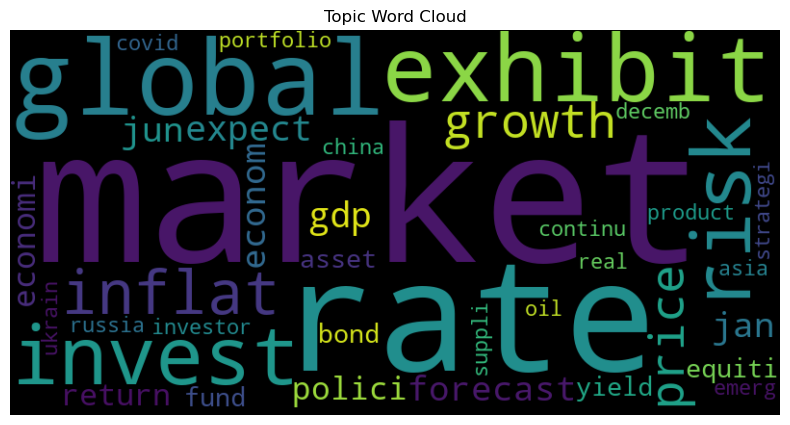

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all topic words into a single string
all_words = ' '.join([word for topic in topic_words for word in topic])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Topic Word Cloud')
plt.show()

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Generate the visualization data
vis_data = gensimvis.prepare(lda_model_2, doc_term_matrix, dictionary_2)
# Plot the interactive visualization
pyLDAvis.display(vis_data)

In [31]:
data['clean_text']=data.groupby('file_name')['text'].transform(lambda x: ' '.join(x))
data.drop_duplicates(subset=['file_name', 'clean_text'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [32]:
data.head()

,file_name,page_num,text,clean_text,tokens,subjectivity_score,date,bank,title,topic
0,01 01 2023_Goldman Sachs_Caution Heavy Fog,1,Outlook Caution: Heavy Fog Investment Strategy...,Outlook Caution: Heavy Fog Investment Strategy...,"['caution', 'heavy', 'fog', 'investment', 'str...",0.476515,01 01 2023,Goldman Sachs,Caution Heavy Fog,1
1,01 07 2022_Unicredit_Economics chartbook Q2,1,3Q 2022 Editor: Chiara Silvestr...,3Q 2022 Editor: Chiara Silvestr...,"['editor', 'chiara', 'silvestre', 'economist',...",0.000000,01 07 2022,Unicredit,Economics chartbook Q2,0
2,01 11 2022_bnp_parisbas global view 2023,1,I N V E S T M E N T O U T L O O K F O R 2 0...,I N V E S T M E N T O U T L O O K F O R 2 0...,"['sustainable', 'investor', 'changing', 'inves...",0.100000,01 11 2022,bnp,parisbas global view 2023,1
3,01 12 2020_UBS_alternative-investments-improvi...,1,For marketing purposes For professional / qual...,For marketing purposes For professional / qual...,"['marketing', 'professional', 'qualified', 'in...",0.550000,01 12 2020,UBS,alternative-investments-improving-portfolio-pe...,0
4,01 12 2022_Goldman Sachs_global view 2023,1,1 Goldman Sachs Asset Management Strategic Adv...,1 Goldman Sachs Asset Management Strategic Adv...,"['asset', 'management', 'strategic', 'advisory...",0.425532,01 12 2022,Goldman Sachs,global view 2023,0


In [70]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import plotly.express as px

vectorizer = CountVectorizer()
processed_docs = data['clean_text'].tolist()
X = vectorizer.fit_transform(processed_docs)
tsne = TSNE(n_components=2, perplexity=4, random_state=0)
X_tsne = tsne.fit_transform(X.toarray())

tsne_df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['title'] = data['title']  

fig = px.scatter(tsne_df, x='Dimension 1', y='Dimension 2', custom_data=['title'],
                 color='title', title='t-SNE Visualization of Documents')
fig.update_traces(marker=dict(size=12, opacity=0.7))
fig.update_layout(hovermode='closest')
fig.update_layout(hoverlabel=dict(namelength=0)) 
fig.update_traces(textposition='top center')  
fig.show()


NameError: name 'data' is not defined

In [46]:
variance_per_dimension = np.var(X_tsne, axis=0)
std_deviation_per_dimension = np.std(X_tsne, axis=0)

print("Variance per dimension:", variance_per_dimension)
print("Standard deviation per dimension:", std_deviation_per_dimension)

Variance per dimension: [2512.615     123.913994]
Standard deviation per dimension: [50.12599  11.131666]


In [13]:
[1,2]+[4,5]

[1, 2, 4, 5]

In [10]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

embedding_df = pd.read_csv('../data/financial_emb.csv')


words_em = embedding_df.iloc[500:649,0]
embedding_matrix = embedding_df.iloc[500:649, 1:].values

tsne = TSNE(n_components=3, perplexity=5, random_state=0,learning_rate=10,n_iter=500)
word_tsne = tsne.fit_transform(embedding_matrix)
tsne_df = pd.DataFrame(word_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

tsne_df['Word'] = list(words_em)
fig = px.scatter_3d(tsne_df, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    text='Word', title='3D t-SNE Visualization of Word Embeddings from CSV',
                    color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.update_layout(hovermode='closest')
fig.update_traces(textposition='top center')  

fig.update_layout(width=1000, height=800)  

fig.show()


     Dimension 1  Dimension 2  Dimension 3       Word
0     -11.732770     8.888331    -4.457830      tilts
1      13.094135     3.744863     0.248683     turner
2      13.109726     3.760818     0.242965      chris
3      -6.833136    -0.167213     6.016998       mild
4      -7.056195   -10.586903     0.181492     cycles
..           ...          ...          ...        ...
144     0.322028    -7.164661     4.195466  weakening
145     0.545009    -5.783148    -4.061032  overnight
146     4.812994    -0.730653    -0.014860   building
147     4.251011    -7.485504     2.782750      spike
148    11.661928    -3.021403    -1.160304      party

[149 rows x 4 columns]


In [10]:
embedding_df=pd.read_csv('../tsne_embeddings/data/Embedding.csv')

In [12]:
embedding_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,inflation,0.021148,0.183663,0.185199,0.054305,0.213899,-0.689852,0.153622,0.751659,-0.252999,...,-0.102017,0.296876,0.116780,0.620217,0.361338,-0.186587,-0.198008,0.227130,-0.055244,NaN
1,growth,-0.024918,0.265209,0.225577,-0.037122,0.347899,-0.311437,0.199655,0.348140,-0.221396,...,0.152925,0.183782,0.123269,0.559711,0.137582,0.092444,-0.265798,-0.120053,-0.274399,NaN
2,exhibit,0.105068,0.126507,0.133156,-0.165486,0.220145,-0.144541,0.417217,0.388043,-0.209632,...,0.093380,0.095718,0.071120,0.643850,0.066595,-0.003790,-0.279589,0.169439,-0.126515,NaN
3,rate,0.117714,0.395059,0.324886,-0.112577,0.122653,-0.631941,0.032977,0.676012,-0.056324,...,-0.034689,0.141461,0.279109,0.504290,0.312376,0.387416,-0.168994,-0.180282,-0.023368,NaN
4,global,-0.112755,0.157177,0.018026,-0.324289,0.305391,-0.167964,0.551484,0.145989,-0.189793,...,0.105124,0.260857,0.081290,0.295890,-0.020125,-0.000292,-0.069617,0.104263,-0.284216,NaN
